In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
import pandas as pd
from lenstools.statistics.ensemble import Series,Ensemble
from lenstools.statistics.constraints import Emulator
from lenstools.statistics.contours import ContourPlot
from lenstools.statistics.samplers import emcee_sampler
from itertools import cycle
import seaborn as sns
import emcee
from matplotlib.colors import LogNorm
from multiprocessing import Pool
from scipy.stats import skew
from scipy.stats import kurtosis as kurt

In [99]:
def standard_error_skew(n):
    return np.sqrt(6*n*(n-1)/((n-2)*(n+1)*(n+3)))

In [100]:
def standard_error_kurt(n):
    return np.sqrt(24*n*(n-1)**2/((n-3)*(n-2)*(n+3)*(n+5)))

In [143]:
datapath = "../power_spectrum.csv"
data = pd.read_csv(datapath)
data.pop("Unnamed: 0")
ell_bins = [f"ell{i}" for i in range(37)]

In [157]:
ell = np.logspace(np.log10(500), np.log10(5000),37)
train_data = data[ell_bins].to_numpy()

In [161]:
gmm = GMM(n_components=2)
# Train gmm on log of power spectrum
gmm.fit(np.log(train_data))

GaussianMixture(n_components=2)

In [163]:
t_skew_real_set = []
t_kurt_real_set = []
t_skew_gmm_set = []
t_kurt_gmm_set = []

n_samples = 2048

SE_skew = standard_error_skew(n_samples)
SE_kurt = standard_error_kurt(n_samples)

for i in range(100):
    # Randomly sample from training data
    ind = np.random.randint(0,train_data.shape[0],n_samples)
    smp_real_data = train_data[ind]
    real_skew = skew(smp_real_data,axis=0)
    real_kurt = kurt(smp_real_data,axis=0)
    
    # Gmm was trained on log of data, so scale back to normal with np.exp
    smp_gmm_data = np.exp(gmm.sample(n_samples=n_samples)[0])
    gmm_skew = skew(smp_gmm_data,axis=0)
    gmm_kurt = kurt(smp_gmm_data,axis=0)
    
    t_skew_real = real_skew/SE_skew
    t_skew_real_set.append(t_skew_real)
    
    t_kurt_real = real_kurt/SE_kurt
    t_kurt_real_set.append(t_kurt_real)
    
    t_skew_gmm = gmm_skew/SE_skew
    t_skew_gmm_set.append(t_skew_gmm)
    
    t_kurt_gmm = gmm_kurt/SE_kurt
    t_kurt_gmm_set.append(t_kurt_gmm)

avg_t_skew_real = np.array(t_skew_real_set).mean(axis=0)
std_t_skew_real = np.array(t_skew_real_set).std(axis=0)

avg_t_kurt_real = np.array(t_kurt_real_set).mean(axis=0)
std_t_kurt_real = np.array(t_kurt_real_set).std(axis=0)

avg_t_skew_gmm = np.array(t_skew_gmm_set).mean(axis=0)
std_t_skew_gmm = np.array(t_skew_gmm_set).std(axis=0)

avg_t_kurt_gmm = np.array(t_kurt_gmm_set).mean(axis=0)
std_t_kurt_gmm = np.array(t_kurt_gmm_set).std(axis=0)

# t-statistics test

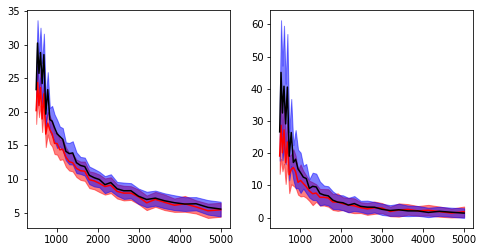

In [164]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(ell,avg_t_skew_real,'r-')
ax[0].fill_between(ell,avg_t_skew_real+std_t_skew_real,avg_t_skew_real-std_t_skew_real,alpha=0.5,color='r')
ax[0].plot(ell,avg_t_skew_gmm,'k-')
ax[0].fill_between(ell,avg_t_skew_gmm+std_t_skew_gmm,avg_t_skew_gmm-std_t_skew_gmm,alpha=0.5,color='b')

ax[1].plot(ell,avg_t_kurt_real,'r-')
ax[1].fill_between(ell,avg_t_kurt_real+std_t_kurt_real,avg_t_kurt_real-std_t_kurt_real,alpha=0.5,color='r')
ax[1].plot(ell,avg_t_kurt_gmm,'k-')
ax[1].fill_between(ell,avg_t_kurt_gmm+std_t_kurt_gmm,avg_t_kurt_gmm-std_t_kurt_gmm,alpha=0.5,color='b')

plt.show()

# GMM power spectrum

In [170]:
# Prepare data for GMM sampled data points
smp_gmm_data = np.exp(gmm.sample(n_samples=n)[0])
ells = smp_gmm_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_gmm_data)))).T
l = ells[:, 1]
P = ells[:,0]

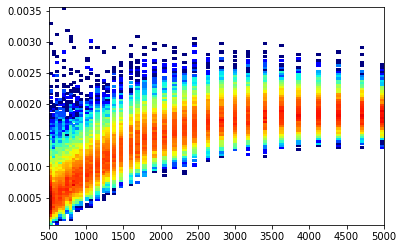

In [171]:
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,l*(l+1)*P, bins=100, cmap="jet", norm=LogNorm())

# Mock data power spectrum

In [172]:
# Prepare data for trained sampled data points
ind = np.random.randint(0,train_data.shape[0],n_samples)
smp_real_data = train_data[ind]
ells = smp_real_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_real_data)))).T
l = ells[:, 1]
P = ells[:,0]

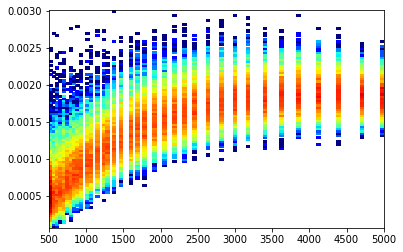

In [173]:
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,l*(l+1)*P, bins=100, cmap="jet", norm=LogNorm())